In [1]:
!pip install transformers accelerate datasets tokenizers seqeval -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00


In [ ]:
! pip install spacy


In [2]:
from datasets import Dataset, ClassLabel, Sequence, load_dataset, load_metric
import numpy as np
import pandas as pd
from spacy import displacy
import transformers
from transformers import (AutoModelForTokenClassification,
                          AutoTokenizer,
                          DataCollatorForTokenClassification,
                          pipeline,
                          TrainingArguments,
                          Trainer)

In [3]:
# confirm version > 4.11.0
print(transformers.__version__)

4.31.0


In [4]:
#dataset ADE-corpus-v2
#https://huggingface.co/datasets/ade_corpus_v2
datasets = load_dataset("ade_corpus_v2", "Ade_corpus_v2_drug_ade_relation")
datasets

Generating train split:   0%|          | 0/6821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'drug', 'effect', 'indexes'],
        num_rows: 6821
    })
})

In [7]:
datasets["train"][0]
# datasets["train"].shape


(6821, 4)

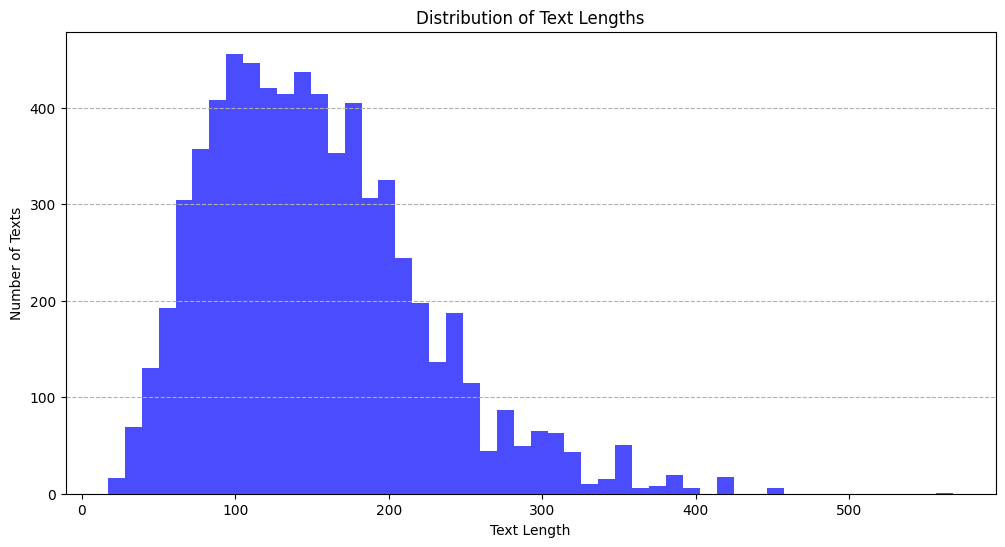

In [6]:
#draw the distribution of the text length
import matplotlib.pyplot as plt

# Assuming you have a list of texts like this:
texts = datasets["train"]['text']

# Calculate lengths of each text
text_lengths = [len(text) for text in texts]

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
plt.title('Distribution of sentences Lengths')
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.grid(axis='y', linestyle='--')
plt.show()


In [8]:
consolidated_dataset = {}

for row in datasets["train"]:
    if row["text"] in consolidated_dataset:
        # consolidated_dataset[row["text"]]["drug_indices_start"].update(row["indexes"]["drug"]["start_char"])
        # consolidated_dataset[row["text"]]["drug_indices_end"].update(row["indexes"]["drug"]["end_char"])
        consolidated_dataset[row["text"]]["effect_indices_start"].update(row["indexes"]["effect"]["start_char"])
        consolidated_dataset[row["text"]]["effect_indices_end"].update(row["indexes"]["effect"]["end_char"])
        # consolidated_dataset[row["text"]]["drug"].append(row["drug"])
        consolidated_dataset[row["text"]]["effect"].append(row["effect"])

    else:
        consolidated_dataset[row["text"]] = {
            "text": row["text"],
            # "drug": [row["drug"]],
            "effect": [row["effect"]],
            # use sets because the indices can repeat for various reasons
            # "drug_indices_start": set(row["indexes"]["drug"]["start_char"]),
            # "drug_indices_end": set(row["indexes"]["drug"]["end_char"]),
            "effect_indices_start": set(row["indexes"]["effect"]["start_char"]),
            "effect_indices_end": set(row["indexes"]["effect"]["end_char"])
        }

df = pd.DataFrame(list(consolidated_dataset.values()))


In [16]:
df.shape

(4271, 4)

In [17]:
df.head()


,text,effect,effect_indices_start,effect_indices_end
0,Intravenous azithromycin-induced ototoxicity.,[ototoxicity],{33},{44}
1,"Immobilization, while Paget's bone disease was...",[increased calcium-release],{143},{168}
2,Unaccountable severe hypercalcemia in a patien...,[hypercalcemia],{21},{34}
3,METHODS: We report two cases of pseudoporphyri...,"[pseudoporphyria, pseudoporphyria]",{32},{47}
4,"Naproxen, the most common offender, has been a...",[erythropoietic protoporphyria],{134},{163}


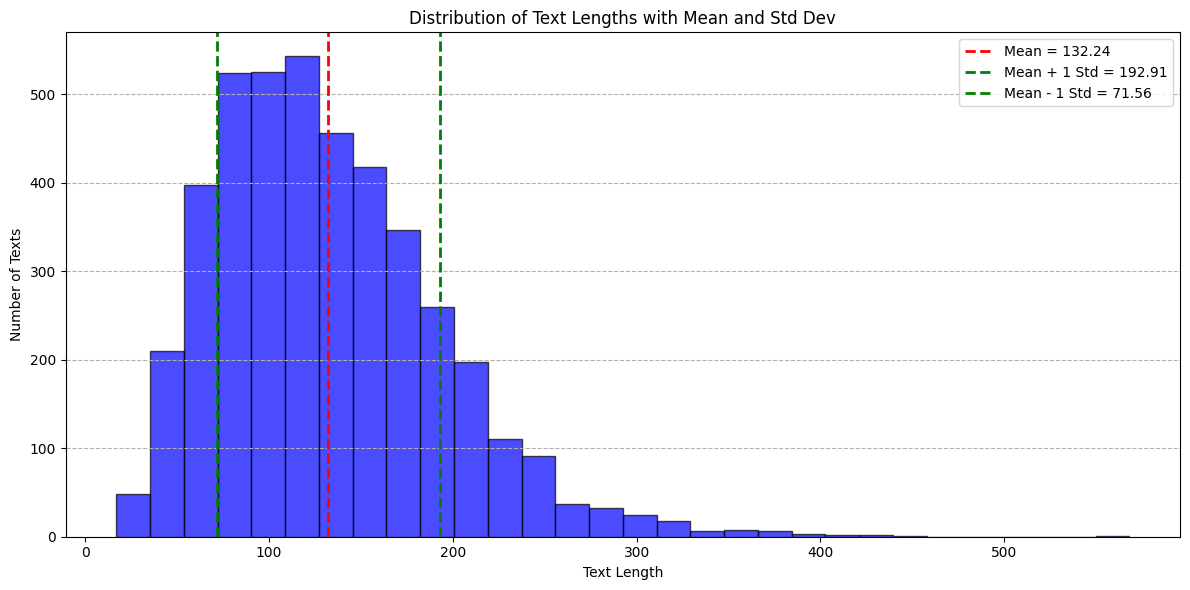

In [18]:
#after merge the repreated sentences, plot each sentences word length distribution.
#draw the distribution of the text length
import matplotlib.pyplot as plt

# Assuming you have a list of texts like this:
texts = df['text']

# Calculate lengths of each text
text_lengths = [len(text) for text in texts]

# Compute statistical measures
mean_length = np.mean(text_lengths)
std_length = np.std(text_lengths)

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')  # You can adjust the number of bins as needed

# Adding vertical lines for mean and standard deviation
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean_length:.2f}')
plt.axvline(mean_length + std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std = {mean_length + std_length:.2f}')
plt.axvline(mean_length - std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std = {mean_length - std_length:.2f}')

plt.title('Distribution of Text Lengths with Mean and Std Dev')
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
# # Plotting the histogram
# plt.figure(figsize=(12, 6))
# plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
# plt.title('Distribution of Text Lengths in ADE_Corpus_V2')
# plt.xlabel('Text Length')
# plt.ylabel('Number of Texts')
# plt.grid(axis='y', linestyle='--')
# plt.show()


In [19]:
## since no spans overlap, we can sort to get 1:1 matched index spans
# note that sets don't preserve insertion order

# df["drug_indices_start"] = df["drug_indices_start"].apply(list).apply(sorted)
# df["drug_indices_end"] = df["drug_indices_end"].apply(list).apply(sorted)
df["effect_indices_start"] = df["effect_indices_start"].apply(list).apply(sorted)
df["effect_indices_end"] = df["effect_indices_end"].apply(list).apply(sorted)


In [20]:
print(len(df['effect']))
print(df.shape)
# print(df['text'][5],df['effect'][5], df['effect_indices_start'][5], df['effect_indices_end'][5])

import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(df['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
all_ae_count = len(flattened_effects)

print("Number of distinct count in 'Adverse Event' terms:", distinct_count)
print("Number of count in 'Adverse Event' terms:", all_ae_count)


# Count the number of terms in each list within 'effect' column
# df['num_terms'] = df['effect'].apply(lambda x: len(x))

# print("total number of Adverse Event Lables:",df['num_terms'].sum())

4271
(4271, 4)
Number of distinct count in 'Adverse Event' terms: 3341
Number of count in 'Adverse Event' terms: 6821


In [21]:
# save to JSON to then import into Dataset object
df.to_json("dataset.jsonl", orient="records", lines=True)

In [22]:
cons_dataset = load_dataset("json", data_files="dataset.jsonl")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [23]:
# no train-test provided, so we create our own
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)



In [24]:
cons_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end'],
        num_rows: 3416
    })
    test: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end'],
        num_rows: 855
    })
})

In [25]:
import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(cons_dataset['train']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
print("Number of count in 'Adverse Event' terms in training:", total_count)

flattened_effects = list(chain.from_iterable(cons_dataset['test']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
print("Number of count in 'Adverse Event' terms in training:", total_count)




Number of distinct count in 'Adverse Event' terms in training: 2837
Number of count in 'Adverse Event' terms in training: 5471
Number of distinct count in 'Adverse Event' terms in training: 903
Number of count in 'Adverse Event' terms in training: 1350


In [27]:

# label_list = ['O', 'B-DRUG', 'I-DRUG', 'B-EFFECT', 'I-EFFECT']
label_list = ['O', 'B-AE', 'I-AE']



custom_seq = Sequence(feature=ClassLabel(num_classes=3,
                                         names=label_list,
                                         names_file=None, id=None), length=-1, id=None)

cons_dataset["train"].features["ner_tags"] = custom_seq
cons_dataset["test"].features["ner_tags"] = custom_seq

In [28]:
#fine-tuning
from transformers import AutoTokenizer

task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "bert-base-uncased"
batch_size = 16

# model_checkpoint = "biomednlp/pubmedbert-base-uncased-abstract"
model_checkpoint = "bert-base-uncased"
# model_checkpoint = "allenai/scibert_scivocab_uncased"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
#function to generate BIO tags for effect
def generate_row_labels(row, verbose=False):
    """ Given a row from the consolidated `Ade_corpus_v2_drug_ade_relation` dataset,
    generates BIO tags for drug and effect entities.

    """

    text = row["text"]

    labels = []
    label = "O"
    prefix = ""

    # while iterating through tokens, increment to traverse all drug and effect spans
    # drug_index = 0
    effect_index = 0

    tokens = tokenizer(text, return_offsets_mapping=True)

    for n in range(len(tokens["input_ids"])):
        offset_start, offset_end = tokens["offset_mapping"][n]

        # should only happen for [CLS] and [SEP]
        if offset_end - offset_start == 0:
            labels.append(-100)
            continue

        # if drug_index < len(row["drug_indices_start"]) and offset_start == row["drug_indices_start"][drug_index]:
        #     label = "DRUG"
        #     prefix = "B-"

        if effect_index < len(row["effect_indices_start"]) and offset_start == row["effect_indices_start"][effect_index]:
            label = "AE"
            prefix = "B-"

        labels.append(label_list.index(f"{prefix}{label}"))

        # if drug_index < len(row["drug_indices_end"]) and offset_end == row["drug_indices_end"][drug_index]:
        #     label = "O"
        #     prefix = ""
        #     drug_index += 1

        if effect_index < len(row["effect_indices_end"]) and offset_end == row["effect_indices_end"][effect_index]:
            label = "O"
            prefix = ""
            effect_index += 1

        # need to transition "inside" if we just entered an entity
        if prefix == "B-":
            prefix = "I-"

    if verbose:
        print(f"{row}\n")
        orig = tokenizer.convert_ids_to_tokens(tokens["input_ids"])
        for n in range(len(labels)):
            print(orig[n], labels[n])
    tokens["labels"] = labels

    return tokens

In [49]:
#labeled_dataset
labeled_dataset = cons_dataset.map(generate_row_labels)


In [51]:
# labeled_dataset['train']

Dataset({
    features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
    num_rows: 3416
})

In [33]:
# word will be splitted into subwords
#test the generate_row_labels function
generate_row_labels(cons_dataset["train"][0], verbose=True)


{'text': 'Anaphylactic reaction to oral prednisone: a case report and review of the literature.', 'effect': ['Anaphylactic reaction'], 'effect_indices_start': [0], 'effect_indices_end': [21]}

[CLS] -100
ana 1
##phy 2
##la 2
##ctic 2
reaction 2
to 0
oral 0
pre 0
##d 0
##nis 0
##one 0
: 0
a 0
case 0
report 0
and 0
review 0
of 0
the 0
literature 0
. 0
[SEP] -100


{'input_ids': [101, 9617, 21281, 2721, 13306, 4668, 2000, 8700, 3653, 2094, 8977, 5643, 1024, 1037, 2553, 3189, 1998, 3319, 1997, 1996, 3906, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 3), (3, 6), (6, 8), (8, 12), (13, 21), (22, 24), (25, 29), (30, 33), (33, 34), (34, 37), (37, 40), (40, 41), (42, 43), (44, 48), (49, 55), (56, 59), (60, 66), (67, 69), (70, 73), (74, 84), (84, 85), (0, 0)], 'labels': [-100, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [34]:
!pip install accelerate -U
# !pip install transformers[torch]

In [35]:
model_name = model_checkpoint.split("/")[-1]
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.05,
    logging_steps=1
)

In [36]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


<ipython-input-36-053592a2c97e>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [40]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # results = metric.compute(predictions=true_predictions, references=true_labels)
    #flat the prediction result
    flat_y_true = [item for sublist in true_labels for item in sublist]
    flat_y_pred = [item for sublist in true_predictions for item in sublist]

    #use the macro average precision, recall, f1 for training
    precision = precision_score(flat_y_true, flat_y_pred, average='macro')
    recall = recall_score(flat_y_true, flat_y_pred, average='macro')
    f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
    accuracy = accuracy_score(flat_y_true, flat_y_pred)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        # "precision": results["overall_precision"],
        # "recall": results["overall_recall"],
        # "f1": results["overall_f1"],
        # "accuracy": results["overall_accuracy"],
    }

In [55]:
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

lltraindata = labeled_dataset['train'].train_test_split(test_size=0.2,seed=42)
print(lltraindata)

DatasetDict({
    train: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 2732
    })
    test: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 684
    })
})


In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report


In [61]:
trainer = Trainer(
    model,
    args,
    train_dataset=lltraindata["train"],
    eval_dataset=lltraindata["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [62]:

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.037300,0.186891,0.883544,0.922682,0.902158,0.954495
2,0.005700,0.178953,0.901083,0.906872,0.903957,0.956639
3,0.047200,0.199179,0.893024,0.921334,0.906687,0.956779
4,0.121100,0.201981,0.895340,0.922408,0.908423,0.957712
5,0.005400,0.209332,0.892807,0.926249,0.908801,0.957152


TrainOutput(global_step=855, training_loss=0.023315925601521258, metrics={'train_runtime': 71.9152, 'train_samples_per_second': 189.946, 'train_steps_per_second': 11.889, 'total_flos': 438057766181016.0, 'train_loss': 0.023315925601521258, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report

predictions, labels, _ = trainer.predict(labeled_dataset["test"])
# print(predictions)
#neural network output classification
predictions = np.argmax(predictions, axis=2)
# print(predictions)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# print(true_predictions)

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
print(len(true_predictions))
print(len(true_labels))
print(true_predictions)
print(true_labels)
results = metric.compute(predictions=true_predictions, references=true_labels)
print(results)

flat_y_true = [item for sublist in true_labels for item in sublist]
flat_y_pred = [item for sublist in true_predictions for item in sublist]

precision = precision_score(flat_y_true, flat_y_pred, average='macro')
recall = recall_score(flat_y_true, flat_y_pred, average='macro')
f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
accuracy = accuracy_score(flat_y_true, flat_y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

report = classification_report(flat_y_true, flat_y_pred, output_dict=True)

report

684
684
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'B-EFFECT', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EFFECT', 'I-EFFECT', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'O', 'O', 'B-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'I-EFFECT', 'O'], ['B-EFFECT', 'I-E

{'B-EFFECT': {'precision': 0.8180904522613065,
  'recall': 0.8696581196581197,
  'f1-score': 0.8430864836872087,
  'support': 936},
 'I-EFFECT': {'precision': 0.8774071060482778,
  'recall': 0.9258729250143103,
  'f1-score': 0.9009887202339507,
  'support': 3494},
 'O': {'precision': 0.9821066443993797,
  'recall': 0.9675637560230345,
  'f1-score': 0.974780961401847,
  'support': 17018},
 'accuracy': 0.9564994405072734,
 'macro avg': {'precision': 0.8925347342363213,
  'recall': 0.9210316002318214,
  'f1-score': 0.9062853884410021,
  'support': 21448},
 'weighted avg': {'precision': 0.9578927623199324,
  'recall': 0.9564994405072734,
  'f1-score': 0.9570125857126671,
  'support': 21448}}

In [ ]:
#show dimensions
num_rows = len(true_predictions)
# Assuming each inner list can have a different length
num_cols_per_row = [len(row) for row in true_predictions]

print("Number of rows for predictions:", num_rows)
print("Number of columns in each row:", num_cols_per_row)


Number of rows: 684
Number of columns in each row: [48, 24, 12, 16, 48, 14, 20, 27, 56, 56, 51, 26, 19, 28, 43, 42, 33, 43, 60, 40, 31, 49, 43, 43, 28, 30, 21, 24, 35, 29, 36, 19, 33, 21, 28, 53, 21, 29, 22, 28, 34, 18, 33, 37, 16, 40, 39, 17, 43, 29, 36, 34, 32, 23, 44, 35, 13, 28, 21, 47, 15, 19, 22, 17, 22, 22, 49, 19, 21, 22, 37, 58, 24, 29, 52, 29, 18, 62, 53, 29, 15, 16, 27, 59, 24, 18, 22, 21, 33, 14, 12, 31, 24, 45, 44, 25, 25, 46, 64, 39, 24, 23, 25, 25, 41, 27, 26, 25, 33, 29, 24, 22, 9, 74, 50, 25, 32, 34, 36, 27, 12, 42, 41, 27, 22, 23, 40, 22, 29, 41, 22, 43, 47, 56, 68, 25, 19, 31, 67, 30, 51, 25, 35, 18, 44, 30, 23, 48, 56, 37, 39, 40, 61, 33, 35, 17, 49, 51, 41, 18, 22, 22, 32, 17, 9, 27, 44, 26, 30, 34, 21, 66, 24, 22, 12, 21, 22, 13, 17, 16, 22, 15, 50, 21, 13, 37, 19, 22, 16, 61, 14, 52, 41, 48, 20, 22, 29, 20, 38, 11, 30, 35, 29, 61, 17, 35, 19, 42, 47, 36, 19, 32, 23, 53, 52, 10, 22, 21, 26, 30, 36, 38, 57, 42, 27, 16, 21, 20, 14, 38, 28, 32, 25, 29, 63, 23, 31, 18

In [ ]:
report

{'B-EFFECT': {'precision': 0.8180904522613065,
  'recall': 0.8696581196581197,
  'f1-score': 0.8430864836872087,
  'support': 936},
 'I-EFFECT': {'precision': 0.8774071060482778,
  'recall': 0.9258729250143103,
  'f1-score': 0.9009887202339507,
  'support': 3494},
 'O': {'precision': 0.9821066443993797,
  'recall': 0.9675637560230345,
  'f1-score': 0.974780961401847,
  'support': 17018},
 'accuracy': 0.9564994405072734,
 'macro avg': {'precision': 0.8925347342363213,
  'recall': 0.9210316002318214,
  'f1-score': 0.9062853884410021,
  'support': 21448},
 'weighted avg': {'precision': 0.9578927623199324,
  'recall': 0.9564994405072734,
  'f1-score': 0.9570125857126671,
  'support': 21448}}

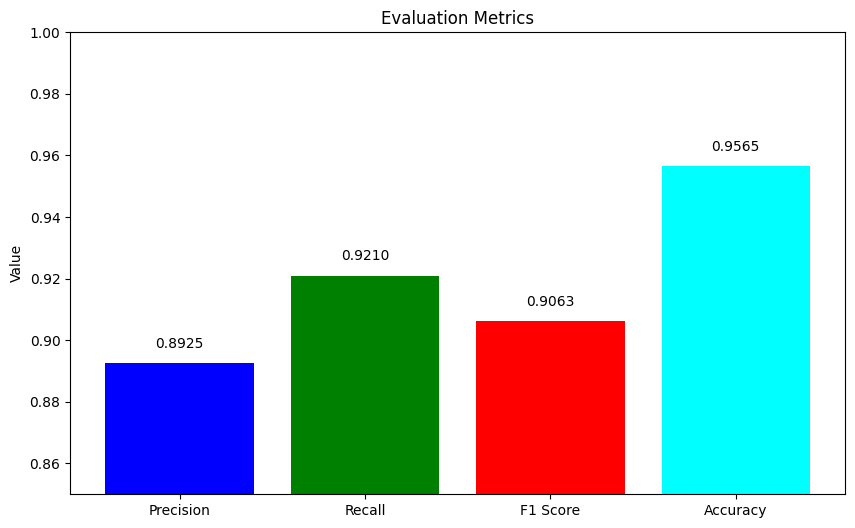

In [ ]:
import matplotlib.pyplot as plt
metrics = {
    'Precision': 0.8925347342363213,
    'Recall': 0.9210316002318214,
    'F1 Score': 0.9062853884410021,
    'Accuracy': 0.9564994405072734
}
# Plotting
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values, color=['blue', 'green', 'red', 'cyan'])
plt.ylim(0.85, 1)  # Setting y-axis limits to better visualize differences
plt.ylabel('Value')
plt.title('Evaluation Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.005, "{:.4f}".format(v), ha='center')  # Displaying the metric values on the bars

plt.show()

In [ ]:

import os
from google.colab import drive

drive.mount('/content/drive')

save_dir = '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/'

# model.save_pretrained("general_ner_model")


model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Mounted at /content/drive


('/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer_config.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/special_tokens_map.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/vocab.txt',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/added_tokens.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer.json')

In [ ]:
effect_ner_model = pipeline(task="ner", model=model, tokenizer=tokenizer)


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
effect_ner_model(labeled_dataset["test"][4]["text"])


[{'entity': 'LABEL_0',
  'score': 0.9986234,
  'index': 1,
  'word': 'to',
  'start': 0,
  'end': 2},
 {'entity': 'LABEL_0',
  'score': 0.99914074,
  'index': 2,
  'word': 'the',
  'start': 3,
  'end': 6},
 {'entity': 'LABEL_0',
  'score': 0.99881774,
  'index': 3,
  'word': 'best',
  'start': 7,
  'end': 11},
 {'entity': 'LABEL_0',
  'score': 0.9990426,
  'index': 4,
  'word': 'of',
  'start': 12,
  'end': 14},
 {'entity': 'LABEL_0',
  'score': 0.9990664,
  'index': 5,
  'word': 'our',
  'start': 15,
  'end': 18},
 {'entity': 'LABEL_0',
  'score': 0.99918145,
  'index': 6,
  'word': 'knowledge',
  'start': 19,
  'end': 28},
 {'entity': 'LABEL_0',
  'score': 0.9991099,
  'index': 7,
  'word': ',',
  'start': 28,
  'end': 29},
 {'entity': 'LABEL_0',
  'score': 0.99923456,
  'index': 8,
  'word': 'this',
  'start': 30,
  'end': 34},
 {'entity': 'LABEL_0',
  'score': 0.99919325,
  'index': 9,
  'word': 'is',
  'start': 35,
  'end': 37},
 {'entity': 'LABEL_0',
  'score': 0.9993149,
  'inde

In [ ]:
#visulization
def visualize_entities(sentence):
    tokens = effect_ner_model(sentence)
    entities = []

    for token in tokens:
        label = int(token["entity"][-1])
        if label != 0:
            token["label"] = label_list[label]
            entities.append(token)

    params = [{"text": sentence,
               "ents": entities,
               "title": None}]

    html = displacy.render(params, style="ent", manual=True, options={
        "colors": {
                   "B-DRUG": "#f08080",
                   "I-DRUG": "#f08080",
                   "B-EFFECT": "#9bddff",
                   "I-EFFECT": "#9bddff",
               },
    })

In [ ]:
examples = [
    "Abortion, miscarriage or uterine hemorrhage associated with misoprostol (Cytotec), a labor-inducing drug.",
    "Addiction to many sedatives and analgesics, such as diazepam, morphine, etc.",
    "Birth defects associated with thalidomide",
    "Bleeding of the intestine associated with aspirin therapy",
    "Cardiovascular disease associated with COX-2 inhibitors (i.e. Vioxx)",
    "Deafness and kidney failure associated with gentamicin (an antibiotic)"
]

for example in examples:
    visualize_entities(example)
    print(f"{'*' * 50}\n")

**************************************************

**************************************************

**************************************************

**************************************************

**************************************************

**************************************************

